 <a href="https://www.homeadvisor.com/"><img src = "https://p.kindpng.com/picc/s/219-2197276_homeadvisor-hd-png-download.png" width = 300, align = "center"></a>

<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> A/B Testing</h1>
Perform a analysis for testing a web page, then find the best values of the parameters 
</div>


In [9]:
"""
Created on Thu Jan-13-2021 at 15:14:36
@author: Sarthak Jagdale (Author info at the bottom of the notebook)


"""
"""
DocString:
A) Introduction:
    This code is written for analyzing old and new web page coversions and lead generation. 
    
    This code has 4 parts
    1> False Positive removal 
    2> Descriptive statistics
    3> Probability testing web page  
    4> OLS 

B) Bugs : 
    ->  There are little to no Bugs in the Code. 

"""

'\nDocString:\nA) Introduction:\n    This code is written for analyzing total cases, stateswise testing, finding correlation between \n    various factors and total cases. \n    \n    This code has a 5 parts\n    1> Null Value removal \n    2> Descriptive statistics\n    3> Plotting values  \n    4> Heat maps\n    5> Infomative Scikit-learn \n\nB) Bugs : \n    ->  There are little to no Bugs in the Code. \n\n'

# Analyze A/B Test Results


A/B tests are very commonly performed by data analysts and data scientists.

<b>Table of Contents</b><br/>
1. Introduction<br/>
2. Part I - Probability<br/>
3. Part II - A/B Test<br/>
4. Part III - Regression<br/>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline

## Import dataset

In [10]:
file_name='ab_data.xlsx'
df=pd.read_excel(file_name)

## Check columns

In [11]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.557,control,old_page,0
1,804228,2017-01-12 08:01:45.160,control,old_page,0
2,661590,2017-01-11 16:55:06.154,treatment,new_page,0
3,853541,2017-01-08 18:28:03.144,treatment,new_page,0
4,864975,2017-01-21 01:52:26.211,control,old_page,1


Check the Number of rows and columns

In [13]:
df.shape

(294478, 5)

The number of unique users in the dataset.

In [14]:
df['user_id'].nunique()


290584

The proportion of users converted.

In [15]:
df.converted.mean()


0.11965919355605512


The number of times the new_page and treatment don't match.




In [16]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

Do any of the rows have missing values?

In [17]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


No null values! lets check again. 


In [18]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [19]:
# Where treatment does not match with new_page or control does not match with old_page
i = df[((df['group']=='treatment') ==(df['landing_page']=='new_page')) == False].index


In [20]:

#Drop these rows 
df2 = df.drop(i)


In [21]:
#Check is the rows are removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]


0

In [22]:
#How many unique user_ids are in df2?
df2['user_id'].nunique()


290584

In [23]:
#duplicate rows 
df2[df2.duplicated(['user_id'], keep=False)]


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.782,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.591,treatment,new_page,0


In [24]:
#Drop the duplicate rows
df2.drop_duplicates(subset ='user_id',keep ='first',inplace = True)


What is the probability of an individual converting regardless of the page they receive?

In [25]:
(df2.query('converted == 1').converted.count())/df2.shape[0]


0.11959708724499628

Given that an individual was in the control group, what is the probability they converted?



In [26]:
control_df = df2.query('group =="control"')
Pold = control_df['converted'].mean()
Pold


0.1203863045004612

Given that an individual was in the treatment group, what is the probability they converted?

In [28]:
# Prob of conversion in treatment group
treatment_df = df2.query('group =="treatment"')
Pnew = treatment_df['converted'].mean()
Pnew 

0.11880806551510564

What is the probability that an individual received the new page?



In [30]:
df2.query('landing_page == "new_page"').landing_page.count()/df2.shape[0]


0.5000619442226688

Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.
From the above results we cannot conclude that new treatment leads to more conversion. As per our analysis we can see that Pnew is smaller than P old.

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.

Analysis: 
    H0 = Pnew <= Pold H1 = Pnew > Pold

Assume under the null hypothesis, 𝑝𝑛𝑒𝑤 and 𝑝𝑜𝑙𝑑 both have "true" success rates equal to the converted success rate regardless of page - that is 𝑝𝑛𝑒𝑤 and 𝑝𝑜𝑙𝑑 are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page.
Use a sample size for each page equal to the ones in ab_data.csv.

Perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.

In [32]:
P_new = treatment_df['converted'].mean()
P_new


0.11880806551510564

What is the conversion rate for  pold  under the null?

In [33]:
P_old = control_df['converted'].mean()
P_old

0.1203863045004612

In [34]:
n_old = control_df.shape[0]
n_old


145274

In [36]:
P_old = control_df['converted'].mean()
P_old


0.1203863045004612

What is  n_new , the number of individuals in the treatment group?

In [37]:
n_new = treatment_df.shape[0]
n_new

145310

In [38]:
new_page_converted = np.random.binomial(1,P_new,n_new)
new_page_converted.mean()

0.11795471750051614

What is  nold , the number of individuals in the control group?

In [39]:
n_old = control_df.shape[0]
n_old

145274

 Simulate  n_new  transactions with a conversion rate of  pnew  under the null. Store these  nnew  1's and 0's in new_page_converted.

In [40]:
new_page_converted = np.random.binomial(1,P_new,n_new)
new_page_converted.mean()

0.11903516619640768

Simulate  nold  transactions with a conversion rate of  pold  under the null. Store these  nold  1's and 0's in old_page_converted.

In [41]:
old_page_converted = np.random.binomial(1,P_old,n_old)
old_page_converted.mean()

0.1194639095777634

Find  pnew  -  pold  for your simulated values 

In [42]:
 new_page_converted.mean() - old_page_converted.mean()

    

-0.0004287433813557201

Create 10,000  pnew  -  pold  values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called p_diffs.

In [43]:
p_diffs =[]
size = df2.shape[0]
for _ in range(10000):
    new_page_converted = np.random.binomial(1,P_new, n_new)
    old_page_converted = np.random.binomial(1,P_old, n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())


Plot a histogram of the p_diffs. Does this plot look like what you expected? Use the matching problem in the classroom to assure you fully understand what was computed here.

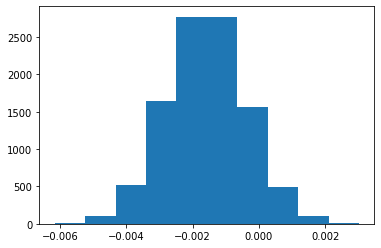

In [44]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

In [45]:
act_new_conversion = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()/n_new

In [46]:
act_old_conversion  = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()/n_old

In [47]:
obs_diff = act_new_conversion - act_old_conversion
obs_diff

-0.0015782389853555567

What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv?

In [48]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

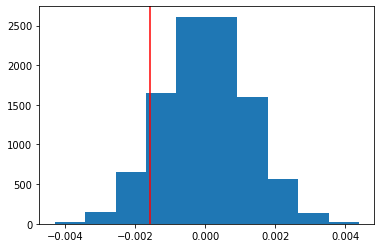

In [49]:
plt.hist(null_vals)
plt.axvline(x=obs_diff,color ='red')

In [50]:
(null_vals > obs_diff).mean()

0.9037

In [51]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

In [52]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [53]:
df2['ab_page'] = pd.get_dummies(df['group']) ['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.557,control,old_page,0,0
1,804228,2017-01-12 08:01:45.160,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.144,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.211,control,old_page,1,0


In [54]:
df2['intercept'] = 1
logit_mod = sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 13 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        23:10:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

Provide the summary of your model below, and use it as necessary to answer the following questions.

In [55]:
np.exp(results.params)


intercept    0.136863
ab_page      0.985123
dtype: float64

In [56]:
1/_

0.00010001000100010001

The p-value associated with logistic regression model is .190 and it is greater than .05 hence once again we failed to reject null hypotheses and unable to establish that landing page is statiscally significant conversion.And the null hypotheses is now there is no difference between the treatment and control group.Alternative hypotheses is that there is difference between between the treatment and control group. New hypotheses are: H0 : Pnew = Pold H1 : Pnew != Pold

<h3>About the Author:</h3>

This notebook was written by <a href="https://www.linkedin.com/in/sarthakarun/" target="_blank">Sarthak Jagdale Dual MSc</a>.

<p><a href="https://sarthakjagdale.github.io" target="_blank">Sarthak Jagdale</a> is a Data Product manager who has an MSc in Data Science, MSc in International Business, and Btech in Electronics and Communication Engineering. His research focused on using Machine Learning, Signal Processing, and Computer Vision to determine how behavior impact human cognition. Sarthak has been working on several projects since he completed his second Master's.</p>